### File locations:
<div class='alert alert-block alert-info'><font color="black">
In the below cell, please enter the file path to the folder where you saved the images and to the folders where the code and external data files were saved. This can be swapped with the existing example.</font>
</div>

In [164]:
# Image files folder
aug_location = r'...\Augmented_Images'

# Location where external data was saved
external_path = r'...\external_data_2.csv'

### Imports:

In [198]:
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam

from keras.layers import Flatten, Input, concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras,os
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from keras.utils import plot_model
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random

In [206]:
# set seeds for reproducibility
np.random.seed(416)
python_random.seed(416)
tf.set_random_seed(416)

## Load Data
The `load_data` function does the following actions: 
1. Load image labels from file path, 
2. Get date from the label, convert to Sunday
3. Sort on (label, match_date)
4. Load external data, drop duplicates, convert to Sunday
5. Bucket external data on percentiles
6. Inner merge external data and labels,
7. Sort on (label, match_date)
8. Read in images as an array in the order & amount of inner join result
9. Return 1) image array 2) merge_with_labels

In [166]:
# Call the load data function from the respective file
%run -i "...\load_data_movAvg.py"

## Get Image Array & Data File

In [167]:
image_array, merge_with_labels, df_for_training = load_data_MA(aug_location, external_path)

In [168]:
#confirm matching length of image array and merge with labels dataframe
print(len(image_array))
print(len(merge_with_labels))

850
850


### Define Continuous Data Pre-Processing Function

In [169]:
#process external data function
def process_structured_data(df, train, test):
    """
    Pre-processes the given dataframe by minmaxscaling the continuous features
    (fit-transforming the training data and transforming the test data)
    """
    continuous = ["Mortgage Rate" , "Percent Delinquent Mortgages", "Unemployment"]
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[continuous])
    testX = cs.transform(test[continuous])
    return (trainX, testX)

## Define Target Variable
Get Y Values from column "buckets" and define `df_for_training`, which has all relevant data for the model input

In [170]:
#define as 4 columns needed to train - remove buckets?
df_for_training = merge_with_labels[["Mortgage Rate" , "Percent Delinquent Mortgages", "Unemployment", "buckets"]].copy()

In [171]:
#split the image and external data into training and test sets 
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df_for_training, image_array, test_size=0.25, random_state=42)

#for bucket classification
trainY = trainAttrX["buckets"]
testY = testAttrX["buckets"]

#convert the buckets into dummies
Ytrain = np_utils.to_categorical(np.asarray(trainY), num_classes=4)
Ytest = np_utils.to_categorical(testY, num_classes=4)

# store train and test index values for regression
trainY_cont = merge_with_labels[merge_with_labels.index.isin(trainAttrX.index)]["Index Wellness"]
testY_cont = merge_with_labels[merge_with_labels.index.isin(testAttrX.index)]["Index Wellness"]

#index values for train and test set
indexvals_train = trainAttrX.index
indexvals_test = testAttrX.index

# normalize input attributes using previously defined function
(trainAttrX, testAttrX) = process_structured_data(df_for_training.iloc[:,0:3], trainAttrX.iloc[:,0:3], testAttrX.iloc[:,0:3])

#### For Model: trainAttrX, testAttrX, Ytrain, Ytest, trainImagesX, testImagesX

### Create Structure for External data to be processed by model

In [172]:
# create model to get input nodes
external_model_ = Sequential()
ext_input_layer = Dense(3, input_dim=trainAttrX.shape[1], activation=None)
external_model_.add(ext_input_layer)

# variable for input into model
ext_data_input = ext_input_layer.input

## Early Stopping functions
Define early stopping parameters to maximize accuracy with a patience of 4 epochs. This will help prevent overfitting.

Checkpoints based on max accuracy validation set accuracy will be saved with respective model naming conventions.

In [207]:
# define early stopping parameters
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=4)
early_stop_res50 = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=10)
                           
# set up model checkpoint based on the name of the model
vgg_checkpt = ModelCheckpoint('best_vgg16.h5', monitor='val_acc', mode='max', verbose=True, save_best_only=True)                           
res1_checkpt = ModelCheckpoint('best_res1.h5', monitor='val_acc', mode='max', verbose=True, save_best_only=True)
res50_checkpt = ModelCheckpoint('best_res50.h5', monitor='val_acc', mode='max', verbose=True, save_best_only=True)
other_checkpt = ModelCheckpoint('best_other.h5', monitor='val_acc', mode='max', verbose=True, save_best_only=True)

<div class='alert alert-block alert-warning'><font color="black"><h1 align='center'>VGG16 Implementation</h1></font></div>

VGG16 structure is adapted from [Thakur's Toward Data Science article](https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c)

The Adam optimizer is used to decide network weights by using the average of the second moments of the gradients.

In [175]:
def VGG16(width, height, depth, regularizer=None):
    
    #define inputs
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape = inputShape)
    
    x = inputs 
    
    #set structure with increasing-in-size convolution layers
    x = Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
    x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x)
    x = Conv2D(128, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(128, (3,3), padding = "same", activation = "relu")(x)
    x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x)
    x = Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = MaxPool2D(pool_size = (2,2), strides = (2,2), name = 'vgg16')(x)
    x = Flatten()(x)
    x = Dense(4096, activation = 'relu', name = 'fc1')(x)
    x = Dense(4096, activation = 'relu', name = 'fc2')(x)
    
    x = Dense(8, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)

    model = Model(inputs,x)
    return model

In [176]:
# Create CNN model
vgg = VGG16(400, 400, 3)

# Create the input to the final set of layers as the external data and the output of the CNN
combinedInput_vgg = concatenate([ext_data_input, vgg.output])

# The final fully-connected layer head will have two dense layers (one relu and one softmax)
# the softmax function classifies the target buckets
final_vgg = Dense(8, activation="relu")(combinedInput_vgg)
final_vgg = Dense(4, activation="softmax")(final_vgg)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model_class_vgg = Model(inputs=[external_model_.input, vgg.input], outputs=final_vgg)

# Compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_class_vgg.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)

In [177]:
# fit VGG16
vgg_history = model_class_vgg.fit(
  [trainAttrX, trainImagesX], 
  Ytrain,
  validation_data=([testAttrX, testImagesX], Ytest), 
  epochs=30,
  batch_size=10,
  callbacks = [early_stop, vgg_checkpt]
)

Train on 637 samples, validate on 213 samples
Epoch 1/30
637/637 [==============================] - 1154s 2s/step - loss: 96.9976 - acc: 0.1695 - val_loss: 1.4043 - val_acc: 0.2535

Epoch 00001: val_acc improved from -inf to 0.25352, saving model to best_vgg16.h5
Epoch 2/30
637/637 [==============================] - 1154s 2s/step - loss: 1.3917 - acc: 0.1821 - val_loss: 1.3574 - val_acc: 0.4178

Epoch 00002: val_acc improved from 0.25352 to 0.41784, saving model to best_vgg16.h5
Epoch 3/30
637/637 [==============================] - 1170s 2s/step - loss: 1.3435 - acc: 0.3878 - val_loss: 1.3163 - val_acc: 0.4178

Epoch 00003: val_acc did not improve from 0.41784
Epoch 4/30
637/637 [==============================] - 1177s 2s/step - loss: 1.3212 - acc: 0.4003 - val_loss: 1.2915 - val_acc: 0.4178

Epoch 00004: val_acc did not improve from 0.41784
Epoch 5/30
637/637 [==============================] - 1189s 2s/step - loss: 1.2952 - acc: 0.4003 - val_loss: 1.2662 - val_acc: 0.4178

Epoch 00005

<div class='alert alert-block alert-warning'><font color="black"><h1 align='center'>ResNet Implementation</h1></font></div>

The below code was adapted from [this tutorial](https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/).

## ResNet1 structure

In [178]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    
    # activation function
    layer_out = Activation('relu')(layer_out)
    
    return layer_out

In [179]:
# function to run model with resnet and output flattened layer
def resnet_run(width, height, depth, n_filters, regularizer=None):
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)

    # define model input
    visible = Input(shape=inputShape)
    
    # add res net module
    layer = residual_module(visible, n_filters)
    layer = Flatten()(layer)
    layer = Dense(8, kernel_regularizer=regularizer, activation = "linear")(layer)
    layer = Activation("relu")(layer)
    
    # Construct the Model
    model = Model(inputs=visible, outputs=layer)
    
    return model

In [180]:
# Create the CNN Resnet models
resnet = resnet_run(400, 400, 3, 64)
 
# Create the input to the final set of layers as the external data and the output of the CNN
combinedInput_res1 = concatenate([ext_data_input, resnet.output])

# The final fully-connected layer head will have two dense layers (one relu and one linear)
# The linear layer is adapted from the original code to accomodate for a regression model
final_res1 = Dense(8, activation="relu")(combinedInput_res1)
final_res1 = Dense(4, activation="softmax")(final_res1)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model_class_res = Model(inputs=[external_model_.input, resnet.input], outputs=final_res1)

# Compile the model 
model_class_res.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)

In [181]:
# Fit the model
model_class_res_history = model_class_res.fit(
  [trainAttrX, trainImagesX], 
  Ytrain, 
  validation_data=([testAttrX, testImagesX], Ytest), 
  epochs=75,
  batch_size=10,
  callbacks = [early_stop, res1_checkpt]
)

Train on 637 samples, validate on 213 samples
Epoch 1/75
637/637 [==============================] - 415s 651ms/step - loss: 6577.9908 - acc: 0.2920 - val_loss: 1.3165 - val_acc: 0.3286

Epoch 00001: val_acc improved from -inf to 0.32864, saving model to best_res1.h5
Epoch 2/75
637/637 [==============================] - 406s 638ms/step - loss: 1.2527 - acc: 0.3626 - val_loss: 1.2313 - val_acc: 0.3333

Epoch 00002: val_acc improved from 0.32864 to 0.33333, saving model to best_res1.h5
Epoch 3/75
637/637 [==============================] - 406s 637ms/step - loss: 1.1825 - acc: 0.3611 - val_loss: 1.1715 - val_acc: 0.2817

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/75
637/637 [==============================] - 404s 634ms/step - loss: 1.1214 - acc: 0.4050 - val_loss: 1.1261 - val_acc: 0.5070

Epoch 00004: val_acc improved from 0.33333 to 0.50704, saving model to best_res1.h5
Epoch 5/75
637/637 [==============================] - 404s 634ms/step - loss: 1.0597 - acc: 0.6060 - val

<div class='alert alert-block alert-warning'><font color="black"><h1 align='center'>ResNet 50: <i>Classification</i></h1></font></div>



In [208]:
# Download the architecture of ResNet50 with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet')
 
# Taking the output of the last convolution block in ResNet50
resnet_50 = base_model.output
 
# Adding a Global Average Pooling layer
resnet_50 = GlobalAveragePooling2D()(resnet_50)
 
# Adding a fully connected layer having 1024 neurons
resnet_50 = Dense(1024, activation='relu')(resnet_50)
 
# Adding a fully connected layer having 4 neurons which will give the probability of imagbeing in each bucket
predictions = Dense(8, activation='relu')(resnet_50)
 
# Model to be trained
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

C:\Users\xu.meng\anaconda3\envs\Keras_Environ\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [209]:
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput_res50 = concatenate([ext_data_input, model_resnet50.output])

# The final fully-connected layer head will have two dense layers (one relu and one softmax)
final_res50 = Dense(8, activation="relu")(combinedInput_res50)
final_res50 = Dense(4, activation="softmax")(final_res50)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model_res50_concat = Model(inputs=[external_model_.input, model_resnet50.input], outputs=final_res50)

# Compile the model using the SGD optimizer
model_res50_concat.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=SGD(lr=0.0001, momentum=0.9))

In [210]:
# Fit the model
model_resnet50_history = model_res50_concat.fit(
  [trainAttrX, trainImagesX], 
  Ytrain, 
  validation_data=([testAttrX, testImagesX], Ytest), 
  epochs=75,
  batch_size=10,
  callbacks = [early_stop_res50, res50_checkpt]
)

Train on 637 samples, validate on 213 samples
Epoch 1/75
637/637 [==============================] - 254s 399ms/step - loss: 1.4443 - acc: 0.1272 - val_loss: 1.4041 - val_acc: 0.1408

Epoch 00001: val_acc improved from -inf to 0.14085, saving model to best_res50.h5
Epoch 2/75
637/637 [==============================] - 246s 386ms/step - loss: 1.3526 - acc: 0.2810 - val_loss: 1.3758 - val_acc: 0.1737

Epoch 00002: val_acc improved from 0.14085 to 0.17371, saving model to best_res50.h5
Epoch 3/75
637/637 [==============================] - 244s 383ms/step - loss: 1.3008 - acc: 0.3312 - val_loss: 1.3548 - val_acc: 0.2254

Epoch 00003: val_acc improved from 0.17371 to 0.22535, saving model to best_res50.h5
Epoch 4/75
637/637 [==============================] - 244s 383ms/step - loss: 1.2631 - acc: 0.3972 - val_loss: 1.3490 - val_acc: 0.2864

Epoch 00004: val_acc improved from 0.22535 to 0.28638, saving model to best_res50.h5
Epoch 5/75
637/637 [==============================] - 244s 382ms/step

<div class='alert alert-block alert-warning'><font color="black"><h1 align='center'>Additional CNN Architecture</h1></font></div>

This architecture uses a more simple CNN architecture that has quicker training time.

In [185]:
def cnn_buckets(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)

     # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
      # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(16, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)    

    # Final layers - flatten the volume, then Fully-Connected => RELU => BN
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer, activation = "softmax")(x)
    x = Activation("softmax")(x)
        
    # Construct the CNN
    model = Model(inputs, x)
        
    # Return the CNN
    return model

In [186]:
cnn3 = cnn_buckets(400, 400, 3)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput_norm = concatenate([ext_data_input, cnn3.output])

# The final fully-connected layer head will have two dense layers (one relu and one linear)
# The linear layer is adapted from the original code to accomodate for a regression model
final_norm = Dense(8, activation="relu")(combinedInput_norm)
final_norm = Dense(4, activation="softmax")(final_norm)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model3 = Model(inputs=[external_model_.input, cnn3.input], outputs=final_norm)

# Compile the model 
model3.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)

In [187]:
model3_history = model3.fit(
  [trainAttrX, trainImagesX], 
  Ytrain, 
  validation_data=([testAttrX, testImagesX], Ytest), 
  epochs=25,
  batch_size=10,
  callbacks = [early_stop, other_checkpt]
)

Train on 637 samples, validate on 213 samples
Epoch 1/25
637/637 [==============================] - 117s 184ms/step - loss: 1.1785 - acc: 0.5133 - val_loss: 1.0123 - val_acc: 0.5446

Epoch 00001: val_acc improved from -inf to 0.54460, saving model to best_other.h5
Epoch 2/25
637/637 [==============================] - 115s 180ms/step - loss: 0.9964 - acc: 0.6546 - val_loss: 0.9442 - val_acc: 0.6620

Epoch 00002: val_acc improved from 0.54460 to 0.66197, saving model to best_other.h5
Epoch 3/25
637/637 [==============================] - 115s 181ms/step - loss: 0.9183 - acc: 0.6735 - val_loss: 0.9015 - val_acc: 0.6620

Epoch 00003: val_acc did not improve from 0.66197
Epoch 4/25
637/637 [==============================] - 115s 180ms/step - loss: 0.8736 - acc: 0.6892 - val_loss: 0.8505 - val_acc: 0.6761

Epoch 00004: val_acc improved from 0.66197 to 0.67606, saving model to best_other.h5
Epoch 5/25
637/637 [==============================] - 115s 180ms/step - loss: 0.8376 - acc: 0.6766 - val

<div class='alert alert-block alert-warning'><font color="black"><h1 align='center'>Visualize Classification Model Results</h1></font></div>

The below visualization code is adapted from [Lewis](https://github.com/L-Lewis/Predicting-traffic-accidents-CNN/blob/master/7_Model3_mixed_input_neural_network.ipynb).

In [188]:
printarch = plot_model(vgg_model, to_file=r"C:\Users\xu.meng\Veronica\vgg_arch.png", show_shapes=True, show_layer_names=True)
printarch = plot_model(model_res50_concat, to_file=r"C:\Users\xu.meng\Veronica\res50_arch.png", show_shapes=True, show_layer_names=True)
printarch = plot_model(model_class_res, to_file=r"C:\Users\xu.meng\Veronica\res1_arch.png", show_shapes=True, show_layer_names=True)

In [189]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    #class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')
        
    plt.colorbar()

In [218]:
def cnn_evaluation(model, history, train_features, train_images, train_labels, test_features, test_images, test_labels, class_names=None, model_name=None):
    """
    Evaluates the performance of a CNN with loss and accuracy plots, a confusion matrix and a classification report for the training and test sets.
    """
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch[1:], train_loss[1:], 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    print('Evaluate the model...')
    results_test = model.evaluate([test_features, test_images], test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    print('Predicting Train and Test sets...')
    y_train_pred = model.predict([train_features, train_images])
    y_pred = model.predict([test_features, test_images])
    
    show_cf(test_labels.argmax(axis=1), y_pred.argmax(axis=1), class_names=class_names, model_name=model_name)
    
    #print(classification_report(train_labels, y_train_pred, target_names = class_names))
    #print(classification_report(test_labels, y_pred,target_names = class_names))

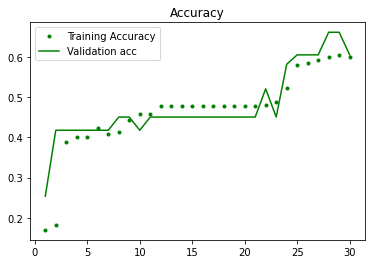

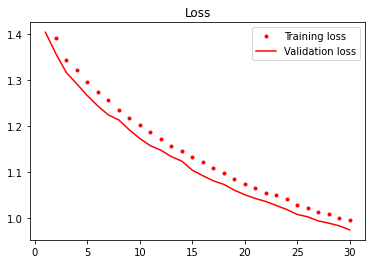

Evaluate the model...
213/213 [==============================] - 132s 622ms/step
Test Loss: 0.8878653508396775
Test Accuracy: 0.7136150002479553
Predicting Train and Test sets...


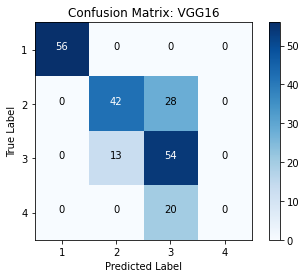

In [221]:
cnn_evaluation(vgg_model, vgg_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'VGG16')

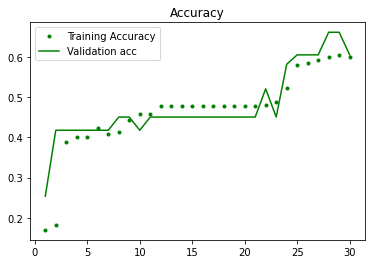

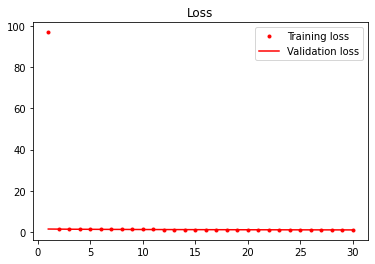

Evaluate the model...
213/213 [==============================] - 134s 629ms/step
Test Loss: 0.9885688633985923
Test Accuracy: 0.6619718074798584
Predicting Train and Test sets...


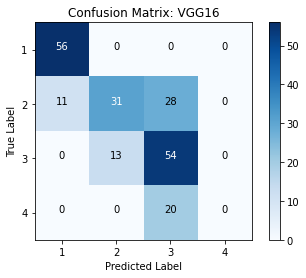

In [214]:
# load best vgg model

#bestvgg_model = load_model(r'C:\Users\xu.meng\Veronica\Augmented_Images\best_vgg16.h5')
cnn_evaluation(bestvgg_model, vgg_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'VGG16')

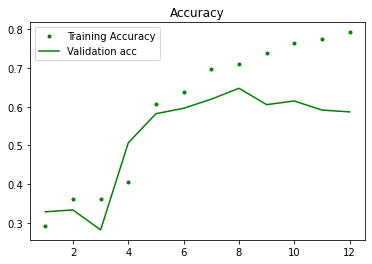

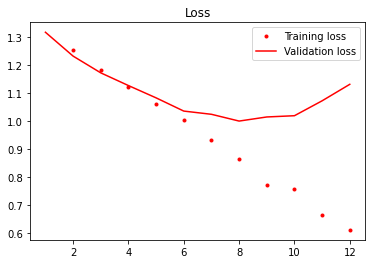

Evaluate the model...
213/213 [==============================] - 32s 150ms/step
Test Loss: 0.9992662105761784
Test Accuracy: 0.6478873491287231
Predicting Train and Test sets...


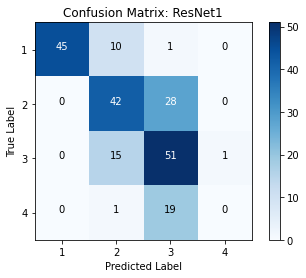

In [220]:
# load best res1 model
bestres1_model = load_model(r'...\best_res1.h5')
cnn_evaluation(bestres1_model, model_class_res_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'ResNet1')

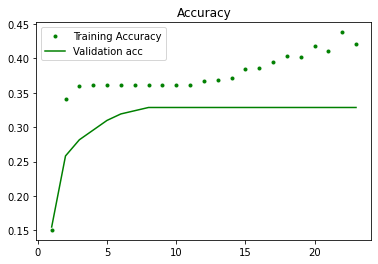

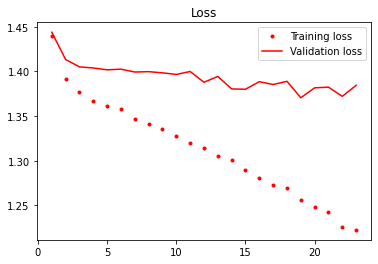

Evaluate the model...
213/213 [==============================] - 55s 259ms/step
Test Loss: 1.384552344469957
Test Accuracy: 0.32863849401474
Predicting Train and Test sets...


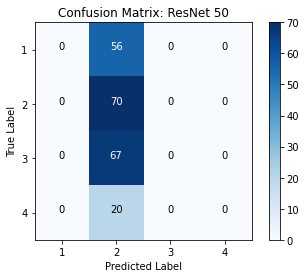

In [203]:
cnn_evaluation(model_res50_concat, model_resnet50_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'ResNet 50')

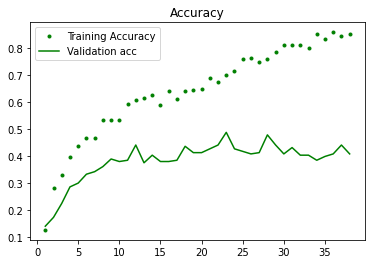

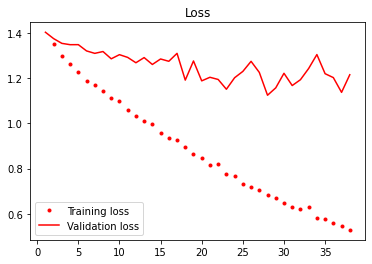

Evaluate the model...
213/213 [==============================] - 64s 298ms/step
Test Loss: 1.151518270443303
Test Accuracy: 0.48826292157173157
Predicting Train and Test sets...


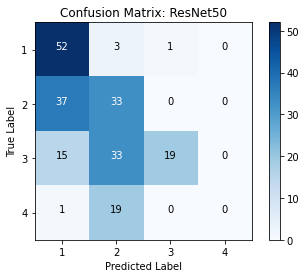

In [222]:
# load best resnet50 model
bestres50_model = load_model(r'...\best_res50.h5')
cnn_evaluation(bestres50_model, model_resnet50_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'ResNet50')

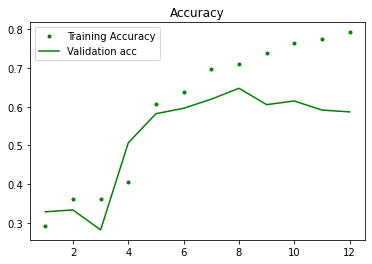

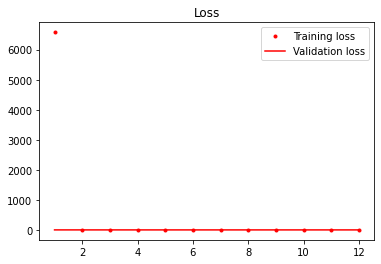

Evaluate the model...
213/213 [==============================] - 28s 134ms/step
Test Loss: 1.1305099305972246
Test Accuracy: 0.5868544578552246
Predicting Train and Test sets...


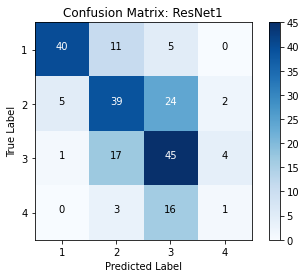

In [204]:
cnn_evaluation(model_class_res, model_class_res_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'ResNet1')

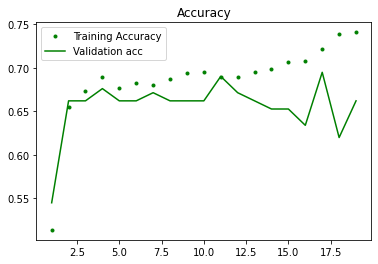

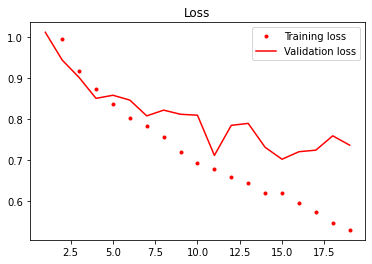

Evaluate the model...
213/213 [==============================] - 8s 37ms/step
Test Loss: 0.7358701206708738
Test Accuracy: 0.6619718074798584
Predicting Train and Test sets...


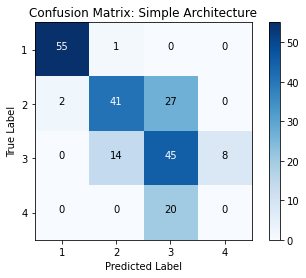

In [223]:
cnn_evaluation(model3, model3_history, trainAttrX, trainImagesX, Ytrain, testAttrX, testImagesX, Ytest, class_names = ['1','2','3','4'], model_name = 'Simple Architecture')

<div class='alert alert-block alert-success'><font color="black"><h1 align='center'>Save Model
    </h1></font></div>

In [163]:
os.chdir(r'...\Prediction')
model_class_vgg.save("vgg_model")

#save other models